# Statistics of ideal mixing
This notebook studies the sampling of the `SaltSwap` code by analyzing transformations where the change in total energy is exactly zero. In particular, the non-bonded parameters of the two TIP3P water molecules are "exchanged" with the non-bonded parameters of two TIP3P water molecules, which are labelled as 'cations' and 'anions'. For these _zero energy swaps_, the statistics of the number of molecules is known exactly. The ratio of water molecules to salt molecules is given by

$$ \exp\left(-\frac{\beta\Delta \mu }{2}\right) = \frac{n_w}{n_s} $$

where $\beta\Delta \mu$ is the applied (dimentionless) difference in chemical potential between water and salt, and $n_w$ and $n_s$ are the number of water molecules and salt molecules respectively. The factor of 1/2 in the exponent comes from the fact that two water molecules are exchanged for two ions.

Testing the agreement of `Saltswap` with the above will be achieved by recording the average ratio of the number of water molecules to anion-cation pairs during simulations at a range of different chemical potentials.

The tests illustrated below are formulized in `test_zero_energy_swaps.py`.

### Results
* <a href='#instant'>Instantaneous swaps</a>
* <a href='#ghmc'>Swaps with NCMC using a GHMC propagator</a>
* <a href='#vv'>Swaps with NCMC using a velocity Verlet propagator</a>

#### Note
In order to account for the correlation in the MCMC chain, the error in average number ratio was be estimated using the standard error multiplied by the (square root of the) integrated autocorrelation time of the ratio. The integrated autocorrelation time is calculated with `pymbar.timeseries`. However, this was still found to underestimate the error, so a factor of 3 was applied to all estimated errors.

In [1]:
# Loading modules
from simtk import openmm, unit
from simtk.openmm import app
from openmmtools.testsystems import WaterBox
import sys
sys.path.append("../saltswap/")
from saltswap.mcmc_samplers import MCMCSampler
import numpy as np
import matplotlib.pyplot as plt
from pymbar import timeseries as ts
from time import time
%matplotlib inline

# Initializing pretty colours taken on 26th Nov 2015 from:
#http://tableaufriction.blogspot.co.uk/2012/11/finally-you-can-use-tableau-data-colors.html
# In order: blue, green, purple, orange. Hopefully a good compromise for colour-blind people.
tableau4 = [(31, 119, 180),(44, 160, 44),(148,103,189),(255, 127, 14)]
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau4)):
    r, g, b = tableau4[i]
    tableau4[i] = (r / 255., g / 255., b / 255.)

** Initializing the simulation parameters **

A box of water will be used as the test system.

In [2]:
# Chemical potentials to test
mus = [-1.0, 0.0, 1.0]      # The applied (delta) chemical potentials in multiples of kT.
mus_axs = np.array(mus)

# Creating the test system
size = 15.0*unit.angstrom
temperature = 300*unit.kelvin
pressure = 1*unit.atmospheres
cutoff = size/2 - 0.5*unit.angstrom   # The electrostatic cutoff. Must be at least half the system size

# Sampling parameters
Nsamps = 100                # The number of sampling blocks
nattempts = 20              # The number of insertion/deletion attempts in a sampling block
skip = 10                   # The number of intial sampling blocks to discard when computing averages (i.e. burn-in)

# NCMC specific parameters
npert = 10              # number of perturbation kernels 
nprop = 1               # number of propagation kernels per perturbation

# Pre-assigment
r_inst = np.zeros(len(mus))      # mean ratio of water to salt for instant switches
r_ghmc = np.zeros(len(mus))      # mean ratio of water to salt for NCMC with GHMC
r_vv = np.zeros(len(mus))        # mean ratio of water to salt for NCMC with velocity Verlet
rstd_inst = np.zeros(len(mus))   # standard deviation of water to salt
rstd_ghmc = np.zeros(len(mus))   
rstd_vv = np.zeros(len(mus))     

<a id='instant'></a>
# Instanstaneous switching

** Simulating **

In [3]:
t = time()
for i in range(len(mus)):
    wbox = WaterBox(box_edge=size,nonbondedMethod=app.PME,cutoff=cutoff)
    dummystate = MCMCSampler(wbox.system,wbox.topology,wbox.positions,delta_chem=mus[i])
    dummystate.saltswap.cation_parameters = dummystate.saltswap.water_parameters
    dummystate.saltswap.anion_parameters = dummystate.saltswap.water_parameters
    dummystate.saltswap._set_parampath()
    ratio = []
    for block in range(Nsamps):
        dummystate.gen_label(saltsteps=nattempts)
        (nwats,nsalt,junk) = dummystate.saltswap.get_identity_counts()
        ratio.append(1.0*nwats/nsalt)
    ratio = np.array(ratio)
    r_inst[i] = ratio[skip:].mean()
    try:
        auto_cor = ts.integratedAutocorrelationTime(ratio[skip:])
    except ts.ParameterError:
        auto_cor = 2
    rstd_inst[i] = ratio[skip:].std()*np.sqrt(auto_cor)
print('Instanstaneous switching test took {0:f} seconds'.format(time() - t))

Instanstaneous switching test took 48.422720 seconds


** Plotting **

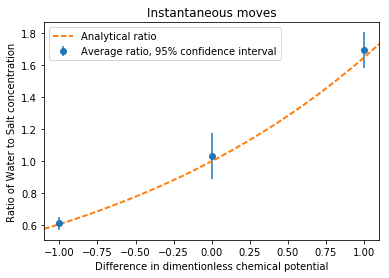

In [4]:
mus_axs = np.array(mus)
delta = 0.1
xlims = (mus[0]-delta,mus[-1]+delta)
x = np.linspace(xlims[0],xlims[1])

plt.clf()
plt.errorbar(mus_axs,r_inst,yerr=1.96*3*rstd_inst/np.sqrt(Nsamps),fmt='o',color=tableau4[0])
plt.plot(x,np.exp(np.array(x)/2), 'r--',linewidth=2,color=tableau4[3])
plt.xlim(xlims)
plt.xlabel('Difference in dimentionless chemical potential')
plt.ylabel('Ratio of Water to Salt concentration')
plt.title('Instantaneous moves')
plt.legend(['Analytical ratio','Average ratio, 95% confidence interval'],loc=2)
plt.show()

<a id='ghmc'></a>
# NCMC with GHMC

** Simulating **

In [5]:
t = time()
for i in range(len(mus)):
    wbox = WaterBox(box_edge=size,nonbondedMethod=app.PME,cutoff=cutoff)
    dummystate = MCMCSampler(wbox.system,wbox.topology,wbox.positions,delta_chem=mus[i],npert=npert,nprop=nprop,propagator='GHMC')
    dummystate.saltswap.cation_parameters = dummystate.saltswap.water_parameters
    dummystate.saltswap.anion_parameters = dummystate.saltswap.water_parameters
    dummystate.saltswap._set_parampath()
    ratio = []
    for block in range(Nsamps):
        dummystate.gen_label(saltsteps=nattempts)
        (nwats,nsalt,junk) = dummystate.saltswap.get_identity_counts()
        ratio.append(1.0*nwats/nsalt)
    ratio = np.array(ratio)
    r_ghmc[i] = ratio[skip:].mean()
    try:
        auto_cor = ts.integratedAutocorrelationTime(ratio[skip:])
    except ts.ParameterError:
        auto_cor = 2
    rstd_ghmc[i] = ratio[skip:].std()*np.sqrt(auto_cor)
print('NCMC test with GHMC took {0:f} seconds'.format(time() - t))

NCMC test with GHMC took 786.522630 seconds


** Plotting **

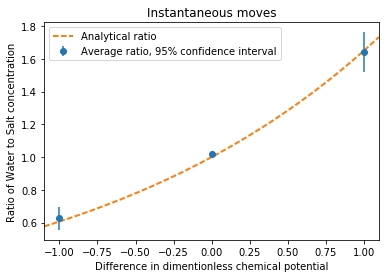

In [6]:
delta = 0.1
xlims = (mus[0]-delta,mus[-1]+delta)
x = np.linspace(xlims[0],xlims[1])

plt.clf()
plt.errorbar(mus_axs,r_ghmc,yerr=1.96*3*rstd_ghmc/np.sqrt(Nsamps),fmt='o',color=tableau4[0])
plt.plot(x,np.exp(np.array(x)/2), 'r--',linewidth=2,color=tableau4[3])
plt.xlim(xlims)
plt.xlabel('Difference in dimentionless chemical potential')
plt.ylabel('Ratio of Water to Salt concentration')
plt.title('Instantaneous moves')
plt.legend(['Analytical ratio','Average ratio, 95% confidence interval'],loc=2)
plt.show()